In [1]:
import pandas as pd
import numpy as np
import string
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Loading the Data

In [2]:
train_df = pd.read_excel('training_data.xlsx')

In [3]:
train_df.shape

(18000, 2)

In [4]:
test_df = pd.read_excel('testing_data.xlsx')
test_df_original = test_df.copy()

In [5]:
test_df.shape

(2000, 1)

# Preprocessing of Training and Test Data

In [6]:
def punctuation(string): 
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    for x in string.lower():
        if x in punctuations: 
            string = string.replace(x, "")
    return string

def clean_text(text):
    text = punctuation(text)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    text = ' '.join(text)
    return text

In [7]:
train_df['service_name'] = train_df['service_name'].map(lambda x: clean_text(x))
train_df['service_category'] = train_df['service_category'].map(lambda x: re.sub(r", ", ",", x))
test_df['service_name'] = test_df['service_name'].map(lambda x: clean_text(x))

In [8]:
train_df.head(10)

,service_name,service_category
0,fade beard trim line,Barber
1,crochet bulk hair,Braids
2,loc maintenance wdemi color,Natural Hair
3,buns ponytails,Style
4,full leg wax arms,Waxing
5,cut blowdry womens cut,Women's Haircut
6,ahb double process color ahb cut,Hair Color
7,gel overlay chrome nails,Manicure
8,mens cut arch wax,"Men's Haircut,Eyebrows"
9,root touch blowout hair glaze treatment partia...,"Hair Color,Style,Hair Treatments,Highlights"


In [9]:
test_df.head(10)

,service_name
0,microlink silk press
1,full sewin leaveout eyebrow arch enhancement f...
2,corrective color cut
3,kae classic special
4,loc style
5,extension take reinstall ombre balayage womens...
6,blc wax nose wax leg wax full
7,full face regular
8,mens cut youth cut
9,lowlights womens haircut add color add root co...


# Preparing Output Labels

In [10]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(","), binary='true')
labels = vectorizer.fit_transform(train_df['service_category']).toarray()

In [11]:
labels.shape

(18000, 32)

In [12]:
n_categories = labels.shape[1]
print(f"number of categories is {n_categories}")

number of categories is 32


# Tokenizing and Padding Input Data (Feature Engineering)

In [13]:
def max_len(x):
    a = x.split()
    return len(a)

In [14]:
max_text_len = max(train_df['service_name'].apply(max_len))
print(f"text maximum length is {max_text_len}")

text maximum length is 22


In [15]:
embed_dim = 50
max_words = 10000

In [16]:
vect = Tokenizer(num_words=max_words)
vect.fit_on_texts(train_df['service_name'])

In [17]:
vocab_size = len(vect.word_index) + 1
max_length = vocab_size
print(f"vocab size and max_length is {vocab_size}")

vocab size and max_length is 5115


In [18]:
encoded_train = vect.texts_to_sequences(train_df['service_name'])
padded_encoded_train = pad_sequences(encoded_train, maxlen=max_text_len, padding='post')
padded_encoded_train

array([[ 165,   59,   11, ...,    0,    0,    0],
       [  66, 1210,    7, ...,    0,    0,    0],
       [  56,   64, 2214, ...,    0,    0,    0],
       ...,
       [  20,   24,   11, ...,    0,    0,    0],
       [   5,   21,  276, ...,    0,    0,    0],
       [  94,   15,    0, ...,    0,    0,    0]], dtype=int32)

In [19]:
padded_encoded_train.shape

(18000, 22)

In [20]:
encoded_test = vect.texts_to_sequences(test_df['service_name'])
padded_encoded_test = pad_sequences(encoded_test, maxlen=max_text_len, padding='post')
padded_encoded_test

array([[1247,   20,   24, ...,    0,    0,    0],
       [   5,   58,  626, ...,    0,    0,    0],
       [ 841,    2,    1, ...,    0,    0,    0],
       ...,
       [ 115,  965,  223, ...,    0,    0,    0],
       [  17,   81,    0, ...,    0,    0,    0],
       [   3,    1,  713, ...,    0,    0,    0]], dtype=int32)

In [21]:
padded_encoded_test.shape

(2000, 22)

# Split Validation and Training Data

In [22]:
X_train, X_val, y_train, y_val = train_test_split(padded_encoded_train, labels, test_size=0.1)

In [23]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(16200, 22)
(16200, 32)
(1800, 22)
(1800, 32)


In [24]:
print(f"the training data length is {X_train.shape[0]} and validation length is {X_val.shape[0]}")

the training data length is 16200 and validation length is 1800


# Creating Stacked LSTM Model

In [25]:
model = keras.Sequential()
model.add(layers.Embedding(vocab_size, output_dim=embed_dim, input_length=max_text_len))
model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.Dropout(0.5))
model.add(layers.LSTM(64))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(n_categories, activation = "sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 22, 50)            255750    
_________________________________________________________________
lstm (LSTM)                  (None, 22, 128)           91648     
_________________________________________________________________
dropout (Dropout)            (None, 22, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
Total params: 398,886
Trainable params: 398,886
Non-trainable params: 0
__________________________________________________

In [26]:
callback_early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)

# Training Model

In [27]:
model.compile(optimizer='adam', loss='binary_crossentropy')
history = model.fit(X_train, y_train,
                    class_weight='balanced',
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[callback_early_stopping])

Train on 16200 samples, validate on 1800 samples
Epoch 1/20
16200/16200 [==============================] - 45s 3ms/sample - loss: 0.1826 - val_loss: 0.1504
Epoch 2/20
16200/16200 [==============================] - 32s 2ms/sample - loss: 0.1557 - val_loss: 0.1513
Epoch 3/20
16200/16200 [==============================] - 32s 2ms/sample - loss: 0.1538 - val_loss: 0.1502
Epoch 4/20
16200/16200 [==============================] - 32s 2ms/sample - loss: 0.1494 - val_loss: 0.1485
Epoch 5/20
16200/16200 [==============================] - 32s 2ms/sample - loss: 0.1375 - val_loss: 0.1253
Epoch 6/20
16200/16200 [==============================] - 32s 2ms/sample - loss: 0.1250 - val_loss: 0.1168
Epoch 7/20
16200/16200 [==============================] - 31s 2ms/sample - loss: 0.1136 - val_loss: 0.1040
Epoch 8/20
16200/16200 [==============================] - 32s 2ms/sample - loss: 0.1024 - val_loss: 0.0958
Epoch 9/20
16200/16200 [==============================] - 31s 2ms/sample - loss: 0.0944 - val_l

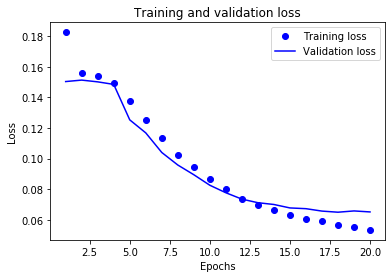

In [28]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Choosing Threshold Based on Micro-Averaged F1-Score

In [29]:
predictions=model.predict([X_val])
thresholds=list(np.arange(0.1, 1, 0.05))
f1_scores = []
for val in thresholds:
    pred=predictions.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(y_val, pred, average='micro')
    recall = recall_score(y_val, pred, average='micro')
    f1 = f1_score(y_val, pred, average='micro')
    f1_scores.append(f1)
   
    print("Micro-average quality numbers for threshold = {:.4f}".format(val))
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print('\n')
threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)
print('Best chosen threshold is {:.4f} with f1-score of {:.4f}'.format(threshold, best_f1))

Micro-average quality numbers for threshold = 0.1000
Precision: 0.5479, Recall: 0.8275, F1-measure: 0.6593
Micro-average quality numbers for threshold = 0.1500
Precision: 0.6229, Recall: 0.7889, F1-measure: 0.6961
Micro-average quality numbers for threshold = 0.2000
Precision: 0.6683, Recall: 0.7581, F1-measure: 0.7104
Micro-average quality numbers for threshold = 0.2500
Precision: 0.7092, Recall: 0.7282, F1-measure: 0.7186
Micro-average quality numbers for threshold = 0.3000
Precision: 0.7422, Recall: 0.7074, F1-measure: 0.7244
Micro-average quality numbers for threshold = 0.3500
Precision: 0.7658, Recall: 0.6831, F1-measure: 0.7221
Micro-average quality numbers for threshold = 0.4000
Precision: 0.7852, Recall: 0.6623, F1-measure: 0.7186
Micro-average quality numbers for threshold = 0.4500
Precision: 0.8017, Recall: 0.6450, F1-measure: 0.7149
Micro-average quality numbers for threshold = 0.5000
Precision: 0.8149, Recall: 0.6259, F1-measure: 0.7080
Micro-average quality numbers for thr

# Training Model Based on All Data for Inference

In [30]:
model = keras.Sequential()
model.add(layers.Embedding(vocab_size, output_dim=embed_dim, input_length=max_text_len))
model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.Dropout(0.5))
model.add(layers.LSTM(64))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(n_categories, activation = "sigmoid"))

In [31]:
model.compile(optimizer='adam', loss='binary_crossentropy')
model.fit(padded_encoded_train, labels,
          class_weight='balanced',
          epochs=20,
          batch_size=32)

Train on 18000 samples
Epoch 1/20
18000/18000 [==============================] - 46s 3ms/sample - loss: 0.1816
Epoch 2/20
18000/18000 [==============================] - 35s 2ms/sample - loss: 0.1554
Epoch 3/20
18000/18000 [==============================] - 34s 2ms/sample - loss: 0.1534
Epoch 4/20
18000/18000 [==============================] - 34s 2ms/sample - loss: 0.1523
Epoch 5/20
18000/18000 [==============================] - 34s 2ms/sample - loss: 0.1390
Epoch 6/20
18000/18000 [==============================] - 35s 2ms/sample - loss: 0.1203
Epoch 7/20
18000/18000 [==============================] - 35s 2ms/sample - loss: 0.1033
Epoch 8/20
18000/18000 [==============================] - 35s 2ms/sample - loss: 0.0923
Epoch 9/20
18000/18000 [==============================] - 34s 2ms/sample - loss: 0.0855
Epoch 10/20
18000/18000 [==============================] - 35s 2ms/sample - loss: 0.0799
Epoch 11/20
18000/18000 [==============================] - 35s 2ms/sample - loss: 0.0750
Epoch 1

# Model Persistence

In [32]:
model.save('multilabel-LSTM-model')

W0307 05:33:21.271945 4533622208 deprecation.py:506] From /Users/yahya/anaconda/envs/tensorflow/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [33]:
restored_model = tf.keras.models.load_model('multilabel-LSTM-model')

# Check its architecture
restored_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 22, 50)            255750    
_________________________________________________________________
lstm_2 (LSTM)                (None, 22, 128)           91648     
_________________________________________________________________
dropout_2 (Dropout)          (None, 22, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
Total params: 398,886
Trainable params: 398,886
Non-trainable params: 0
________________________________________________

# Generating Predictions for Testing Data Based on the Chosen Threshold 

In [34]:
predictions = restored_model.predict(padded_encoded_test)

In [35]:
predictions.shape

(2000, 32)

In [36]:
def get_test_pred_df(test_df, predictions, threshold, vectorizer):
    
    test_df_edited = test_df.copy()
    test_preds = predictions.copy()
    test_preds[test_preds >= threshold]=1
    test_preds[test_preds < threshold]=0
    label_names = vectorizer.get_feature_names()
    x = pd.SparseDataFrame(test_preds, columns=label_names, index=test_df.index, default_fill_value=0)
    cols = x.columns
    bt = x.apply(lambda x: x > 0)
    bt = bt.apply(lambda x: list(cols[x.values]), axis=1)
    bt = bt.apply(lambda x: ', '.join(x))
    test_df_edited['service_categories'] = bt
    
    return test_df_edited

In [37]:
test_df_final = get_test_pred_df(test_df_original, predictions, threshold, vectorizer)
test_df_final['service_categories'] = test_df_final['service_categories'].apply(lambda x: np.nan if not x else x)

In [38]:
test_df_final.head(10)

,service_name,service_categories
0,Microlink silk press,natural hair
1,"Full sewin no leaveout, Eyebrow Arch + enhance...","skincare, weaves"
2,Corrective Color no cut,"hair color, women's haircut"
3,KAE Classic *$70 SPECIAL*,eyelashes
4,loc style,locs
5,"Extension take out with Re-INSTALL, Ombre/ Bal...","highlights, style"
6,"BLC Wax, Nose Wax, Leg Wax - Full",waxing
7,Full Face (Regular),makeup
8,"Men's Cut, Youth Cut (12 & Under)",men's haircut
9,"Lowlights, Women's Haircut (add on for color )...","hair color, highlights"


# Filling in Missing Predictions based on Inference with a Lower Threshold

In [39]:
test_df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
service_name          2000 non-null object
service_categories    1960 non-null object
dtypes: object(2)
memory usage: 31.3+ KB


In [40]:
test_df_1 = get_test_pred_df(test_df_original, predictions, 0.1, vectorizer)
test_df_1['service_categories'] = test_df_1['service_categories'].apply(lambda x: np.nan if not x else x)

In [41]:
test_df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
service_name          2000 non-null object
service_categories    1999 non-null object
dtypes: object(2)
memory usage: 31.3+ KB


In [42]:
test_df_final['service_categories'].fillna(test_df_1['service_categories'], inplace = True)

In [43]:
test_df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
service_name          2000 non-null object
service_categories    1999 non-null object
dtypes: object(2)
memory usage: 31.3+ KB


# Stroing Testing Data with Generated Predictions

In [44]:
test_df_final.to_csv('yahya_submission_problem_1.csv', index = False, header=True)